# Classification Practicum with Class Imbalance


In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Handling Class Imbalance

### Reading in credit card data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/nyc-mhtn-ds-042219-lectures/master/Module_4/classification_evaluation_mini_project/classification_lab_data.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,50000,1,2,2,49,0,0,0,0,0,...,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
1,30000,1,2,1,39,0,0,0,0,0,...,16469,14670,11214,2007,2000,2000,417,1500,1500,0
2,260000,1,1,2,27,0,0,0,0,0,...,76699,56738,39134,30000,4132,3410,2600,1800,1200,0
3,200000,2,2,1,33,0,0,0,0,0,...,25237,22131,13774,4000,2000,600,3000,4000,100,0
4,50000,1,1,2,27,0,0,0,0,0,...,17653,17697,18068,1558,1278,1589,633,656,783,0


In [23]:
df.rename(index=str, columns={"default payment next month": "DEFAULT"}, inplace=True)

In [24]:
# Create matrix of features
X = df.drop('DEFAULT', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = df['DEFAULT'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [25]:
feature_cols

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

## Visualizing Class Imbalance

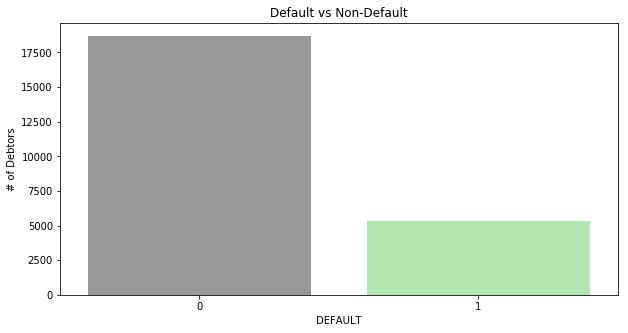

In [6]:
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Default vs Non-Default')
plt.ylabel('# of Debtors')
plt.show()

## Run a Dummy Classifier for Baseline Assessment

In [8]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)



scaler = StandardScaler()  
scaler.fit(X_train)



X_train = pd.DataFrame(scaler.transform(X_train), columns=feature_cols)
X_test  = pd.DataFrame(scaler.transform(X_test), columns=feature_cols)


/Users/swilson5/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/swilson5/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/swilson5/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


Let's compare upsampling and downsampling techniques using the KNN classifier with n_neighbors=9

## Prepping data for handling class imbalances

We are goign to change the training dataset to which we fit our model, so we want to bring our training data back together before we make those changes. 

In [9]:
# concatenate our training data back together
resampling = X_train.copy()
resampling['DEFAULT']= y_train.values

In [10]:

# separate minority and majority classes
good_standing = resampling[resampling['DEFAULT']==0]
defaulted = resampling[resampling['DEFAULT']==1]
# Get a class count to understand the class imbalance.
print('good count: '+ str(len(good_standing)))
print('defaulted count: '+ str(len(defaulted)))

good count: 14017
defaulted count: 3982


# Upsampled Example

In [11]:
# upsample minority
defaulted_upsampled = resample(defaulted,
                          replace=True, # sample with replacement
                          n_samples=len(good_standing), # match number in majority class
                          random_state=23) # reproducible results

In [12]:
# combine majority and upsampled minority
upsampled = pd.concat([good_standing, defaulted_upsampled])

# check new class counts
upsampled['DEFAULT'].value_counts()

1    14017
0    14017
Name: DEFAULT, dtype: int64

In [13]:
# trying logistic regression again with the balanced dataset
y_train_upsampled = upsampled['DEFAULT']
X_train_upsampled = upsampled.drop('DEFAULT', axis=1)

In [14]:
#fit Model to resampled data

knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train_upsampled, y_train_upsampled)

y_pred_class = knn.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_class))



Test Accuracy score:  0.6545
Test F1 score:  0.4502784407319013


# Upsampling with Smote

In [15]:
sm = SMOTE(random_state=23, ratio=1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [16]:
#fit Model to resampled data

knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train_sm, y_train_sm)

y_pred_class = knn.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_class))


Test Accuracy score:  0.6571666666666667
Test F1 score:  0.4591112279779122


# Downsampled Example

In [17]:
# downsample majority
good_standing_downsampled = resample(good_standing,
                                replace = False, # sample without replacement
                                n_samples = len(defaulted), # match minority n
                                random_state = 23) # reproducible results


In [18]:
# combine majority and upsampled minority
downsampled = pd.concat([good_standing_downsampled, defaulted])

# check new class counts
downsampled['DEFAULT'].value_counts()

1    3982
0    3982
Name: DEFAULT, dtype: int64

In [19]:
# trying logistic regression again with the balanced dataset
y_train_downsampled = downsampled['DEFAULT']
X_train_downsampled = downsampled.drop('DEFAULT', axis=1)

In [20]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train_downsampled, y_train_downsampled)

y_pred_class = knn.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_class))


Test Accuracy score:  0.695
Test F1 score:  0.4873949579831934


# Downsample with Tomek Links

In [21]:
tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(X_train, y_train)

In [22]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_tl, y_tl)

y_pred_class = knn.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_class))

Test Accuracy score:  0.8023333333333333
Test F1 score:  0.4714795008912656
